In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, StratifiedShuffleSplit, GroupKFold, KFold, StratifiedGroupKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
import keras
import numpy as np
from scipy.stats import randint
import joblib

pclass: Status sócio-econômico
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

In [2]:
df = pd.read_csv('train.csv', sep=',')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Antes de realizar a análise exploratória, iremos realizar um *LabelEncoder* da coluna "Sex", porém de forma manual com replace.

In [3]:
df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

Caso masculino, será true, caso feminino, será false.

In [4]:
aux = pd.get_dummies(df['Sex'], drop_first=True) # Drop_first true para evitar multicolinearidade

df = pd.concat([df, aux], axis=1)
df.drop('Sex', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,True


### Análise exploratória

**Explicação sobre o que representam os Quartis**

1° Quartil (25%):
- Representa o **valor abaixo do qual 25%** dos dados estão abaixo, por exemplo, a coluna **Age (idade)** é 20 (arredondado), ou seja, **25% dos passageiros tem menos de 20 anos**.

2° Quartil (50%):
- Representa o **valor abaixo do qual 50%** dos dados estão abaixo. A coluna *Age* é 28, ou seja, **50% dos passageiros tem idade inferior a 28 anos**, assim como, **50% dos passageiros tem idade superior a 28 anos**.
- Normalmente, o 2° Quartil (Q2) também pode ser a **mediana**.

3° Quartil (75%):
- Representa o **valor abaixo do qual 75%** dos dados estão abaixo. A coluna *Age* é 38, ou seja, **75% dos passageiros tem idade inferior a 38 anos**, assim como, **25% dos passageiros tem idade superior a 38 anos**.

**Para que servem?**

Os quartis ajudam a resumir e entender a distribuição dos dados sem precisar olhar todos os valores, identificando valores baixos, médios e altos. Na estátistica e análise de dados, são usados também para **detectar outliers** (valores extremos).

**Como são detectados os outliers?**

Se um dado está **muito abaixo** do 1° Quartil (Q1 - 25%) ou **muito acima** do 3° Quartil (Q3 - 75%), pode ser um valor atípico.

**Explicação sobre desvio padrão**

O **desvio padrão** é uma medida da **dispersão** dos dados **em torno da média**. Ele indica o quão espalhados os valores estão em relação à média. Um desvio padrão alto significa que os dados estão mais dispersos (os valores estão distantes da média), enquanto um desvio padrão baixo significa que estão mais próximos da média.

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Mediana**

O 2° Quartil (Q2) também pode ser considerada como a **mediana**, pois é o valor central de um array ordenado.

- Caso o número de elementos for **ímpar**, a **mediana é o valor central**.
- Caso o número de elementor for **par**, a **mediana é a média dos dois valores centrais**.

In [6]:
# Para exemplificar, exibe a mediana do valor central.
# É possível observar que tem o mesmo valor do Q2 (50%)
df['Age'].median()

np.float64(28.0)

In [7]:
df.info()

# Age -> substituir dados nulos pela média ou mediana baseado na pclass (status sócio-econômico)

# Embarked -> Já que são poucos dados nulos, creio que não terá problema desconsiderá-los

# Cabin -> A identificação da cabine seria um dado interessante para determinar se um passageiro poderia sobreviver ou não[...]
# [...] Porém, já que temos muitos dados nulos, talvez não deveriamos considerar esta coluna (?)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  male         891 non-null    bool   
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 77.6+ KB


Podemos criar algumas hipóteses e validar sua veracidade, como por exemplo, pessoas de classes mais altas (status sócio-econômico) tiveram mais probabilidade de sobrevivência?

Primeiramente, iremos verificar qual o percentual de pessoas na 1° classe que sobreviveram.

In [8]:
df_pclass1 = df.query('Pclass == 1')
df_pclass1_survived = df_pclass1.query('Survived == 1')

print("Pessoas na 1° classe que sobreviveram:", len(df_pclass1_survived))
print("Total de passageiros na 1° classe:", len(df_pclass1))
print("Sobreviveram: ", round((len(df_pclass1_survived) * 100) / len(df_pclass1)), '%')

Pessoas na 1° classe que sobreviveram: 136
Total de passageiros na 1° classe: 216
Sobreviveram:  63 %


Em seguida, iremos verificar o percentual de pessoas em outras classes (2° e 3°) que sobreviveram.

In [9]:
df_pclass = df.query('Pclass != 1')
df_pclass_survived = df_pclass1.query('Survived == 1')

print("Pessoas nas outras classes que sobreviveram:", len(df_pclass_survived))
print("Total de passageiros nas outras classes:", len(df_pclass))
print("Sobreviveram: ", round((len(df_pclass_survived) * 100) / len(df_pclass)), '%')

Pessoas nas outras classes que sobreviveram: 136
Total de passageiros nas outras classes: 675
Sobreviveram:  20 %


A partir da análise, infelizmente é possível afirmar que pessoas da 1° classe tinham mais probabilidade de sobreviver que pessoas da 2° ou 3° classe.

Vamos analisar quantas pessoas de cada um dos 3 pontos de embarque sobreviveram.

In [10]:
df_embarked_grouped = df.groupby('Embarked')
df_embarked_grouped.size() # Conta quantos itens tem em cada grupo

Embarked
C    168
Q     77
S    644
dtype: int64

In [11]:
# Quantidade de pessoas que sobreviveram de cada ponto de embarque
df_embarked_grouped['Survived'].sum()

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64

Sobreviveram mais mulheres ou homens?

In [12]:
woman = df.query('male == False')
man = df.query('male == True')

print('Total mulheres', len(woman))
print('Mulheres sobreviventes', woman['Survived'].sum(), '\n')
print('Total homens', len(man))
print('Homens sobreviventes', man['Survived'].sum())

Total mulheres 314
Mulheres sobreviventes 233 

Total homens 577
Homens sobreviventes 109


Todas as crianças sobreviveram?

In [13]:
df_children = df.query('Age < 14')

print('Quantidade de crianças a bordo:', len(df_children))
print('Quantidade de crianças sobreviventes:', df_children['Survived'].sum())
print('Percentual de crianças sobreviventes:', round((df_children['Survived'].sum() * 100) / len(df_children)), '%')

Quantidade de crianças a bordo: 71
Quantidade de crianças sobreviventes: 42
Percentual de crianças sobreviventes: 59 %


Quantidade de crianças por classe.

In [14]:
df_children['Pclass'].value_counts()

Pclass
3    49
2    18
1     4
Name: count, dtype: int64

Quantas crianças de cada classe sobreviveram?

A função *agg* aplica funções ao mesmo tempo.
- Sum adquire o total de sobreviventes.
- Count adquire o total de crianças na classe.

In [15]:
df_children_grouped = df_children.groupby('Pclass') # Crianças agrupadas pela classe
summary = df_children_grouped['Survived'].agg(['sum', 'count'])
summary['Taxa de sobrevivência (%)'] = round(summary['sum'] / summary['count'] * 100, 2) # Total de sobreviventes / Total de crianças * 100
summary = summary.rename(columns={'sum': 'Sobreviventes', 'count': 'Total de crianças'})

summary

,Sobreviventes,Total de crianças,Taxa de sobrevivência (%)
Pclass,,,
1,3,4,75.00
2,18,18,100.00
3,21,49,42.86


Taxa de sobrevivencia geral.

In [16]:
survive_rate_summary = df.groupby('Pclass')['Survived'].agg(['sum', 'count'])
survive_rate_summary['Taxa_sobrevivencia_%'] = round(survive_rate_summary['sum'] / survive_rate_summary['count'] * 100, 2)
survive_rate_summary = survive_rate_summary.rename(columns={'sum': 'Sobreviventes', 'count': 'Total de passageiros'})

survive_rate_summary

,Sobreviventes,Total de passageiros,Taxa_sobrevivencia_%
Pclass,,,
1,136,216,62.96
2,87,184,47.28
3,119,491,24.24


**Engenharia de features**

Criação de novas features para auxiliar o modelo na classificação.

Criação de coluna que representa a taxa de sobrevivência baseada na coluna "Pclass".

In [17]:
survive_rate_dict = survive_rate_summary['Taxa_sobrevivencia_%'].to_dict() # Cria um dicionário onde Pclass é a chave e a taxa de sobrevivência é o valor
survive_rate_dict

{1: 62.96, 2: 47.28, 3: 24.24}

In [18]:
df['Pclass_survive_rate'] = df['Pclass'].map(survive_rate_dict)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,Pclass_survive_rate
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,True,24.24
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False,62.96
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,24.24
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False,62.96
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,True,24.24


Variável para representar o tamanho da família, será 1 no caso de estar sozinho.

In [19]:
df['familySize'] = df['SibSp'] + df['Parch'] + 1

df['isAlone'] = (df['familySize'] == 1).astype(bool)

Agora vamos analisar como os dados estão distribuidos com um histograma.

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Pclass_survive_rate'}>,
        <Axes: title={'center': 'familySize'}>]], dtype=object)

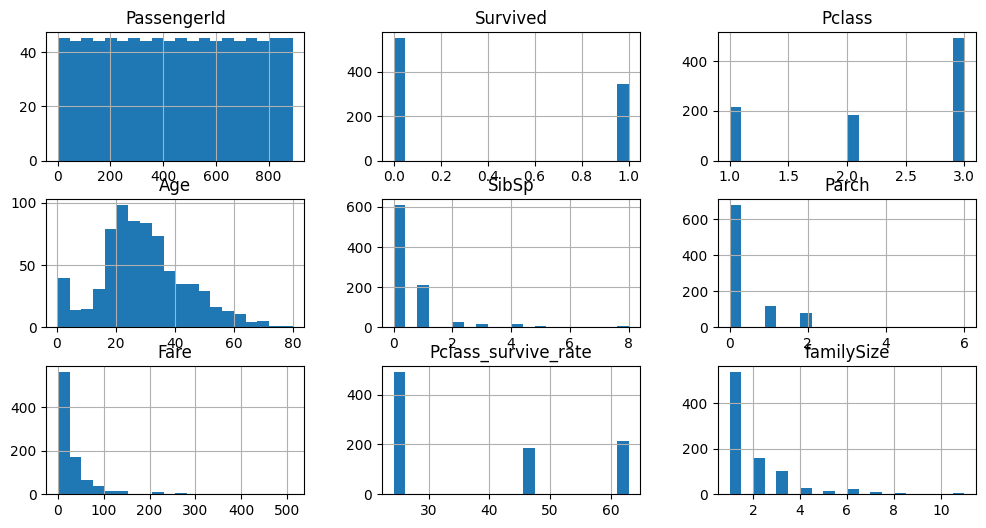

In [20]:
df.hist(figsize=(12,6), bins=20)

Também é interessante verificarmos se há alguns outliers a partir de um boxplot.

Temos outliers principalmente nas colunas *Age* (idade) e *Fare* (tarifa).

<Axes: >

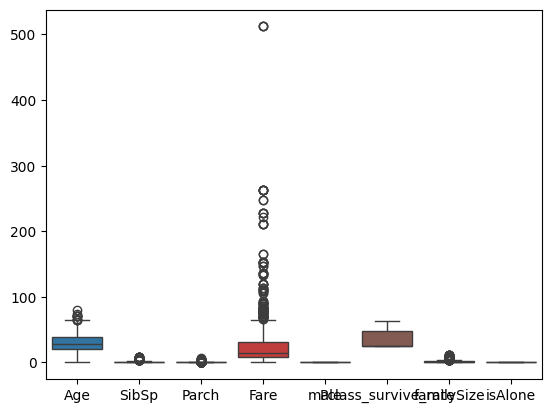

In [21]:
sns.boxplot(df.drop(['PassengerId', 'Survived', 'Pclass'], axis=1))

<Axes: >

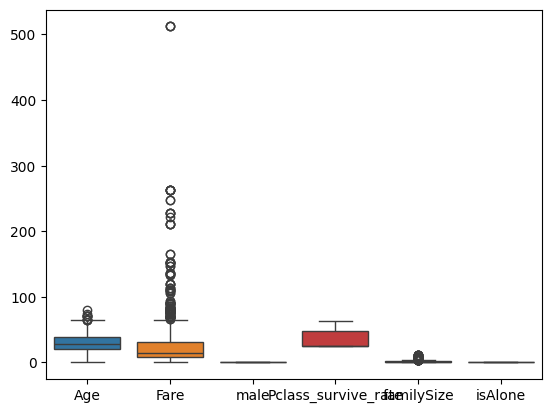

In [22]:
sns.boxplot(df.drop(['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'], axis=1))

Podemos também analisar a correlação para cada coluna, isto é, o quanto cada variável se relaciona entre si.

In [23]:
corr = df.select_dtypes(include=['number','float']).corr()

**Observações sobre as correlações**

É possível visualizar no mapa de calor abaixo (gráfico de correlação) que a variável **Pclass** tem uma correlação negativa com a variável alvo **Survived**, onde quando *Pclass* diminui, Survived aumenta (ou seja, é próximo de 1/true).

*Fare* (tarifa) tem uma correlação negativa com *Survived*, o que significa que a medida que a tarifa sobe, Survived é 1. Porém, não é uma correlação tão precisa quanto a variável categórica *Pclass*.

Inclusive, também há uma forte correlação negativa entre *Pclass* e *Fare*, significando que a medida que *Fare* sobe a *Pclass* é menor, em outras palavras, tarifas mais altas correspondem a classes mais caras (como por exemplo, a 1° classe).

Também há uma outra forte correlação negativa de *Survived* com *Sex*, indicando que a medida que Sex aumenta (1 feminino, 2 masculino) Survived diminui. O motivo disto é pelo fato de que mais mulheres sobreviveram do que homens.

A variável de taxa de sobrevivência (survive_rate) tem uma perfeita correlação negativa com o Pclass, talvez a ideia de criar novas features baseado na taxa de sobrevivência não foi tão boa, pois são variáveis que se correlacionam entre si, o que pode causar multicolinearidade no modelo.

**Dúvidas**
- Por mais que mulheres e crianças eram a prioridade para serem salvas no bote salva vidas a variável Age não tem uma correlação significativa com a variável alvo (Survived), que talvez poderia indicar quanto menor a idade, maior a chance de sobreviver. Porém, não é isto que os dados indicam.

<Axes: >

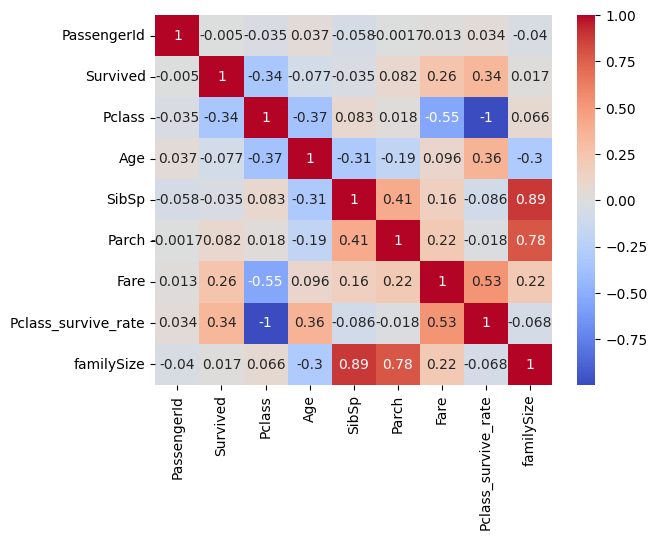

In [24]:
sns.heatmap(corr, annot=True, cmap='coolwarm')

### Pré-processamento dos dados

Antes de tudo, iremos substituir os valores nulos na coluna *Age* pela mediana de idade de passageiros em cada classe.

In [25]:
# Exibe os quartis de idade agrupados pelo n° da classe
df.groupby('Pclass')['Age'].quantile([0, .25, .50, .75, 1]).unstack() # unstack produz um dataframe como resultado

,0.00,0.25,0.50,0.75,1.00
Pclass,,,,,
1,0.92,27.0,37.0,49.0,80.0
2,0.67,23.0,29.0,36.0,70.0
3,0.42,18.0,24.0,32.0,74.0


O código abaixo calcula a mediana da idade para cada classe (Pclass).

A função *fillna* irá substituir os valores nulos pelo valor passado no parâmetro.

Agrupa os passageiros por classe, adquire a idade e, por fim, a função *transform('median')* retorna a mediana das idades dos passageiros agrupados pela classe, para cada linha do dataset.

In [26]:
df['Age'] = df['Age'].fillna(df.groupby('Pclass')['Age'].transform('median'))

In [27]:
# Iremos desconsiderar as colunas Cabin, por isso não iremos preencher estes dados ausentes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Name                 891 non-null    object 
 4   Age                  891 non-null    float64
 5   SibSp                891 non-null    int64  
 6   Parch                891 non-null    int64  
 7   Ticket               891 non-null    object 
 8   Fare                 891 non-null    float64
 9   Cabin                204 non-null    object 
 10  Embarked             889 non-null    object 
 11  male                 891 non-null    bool   
 12  Pclass_survive_rate  891 non-null    float64
 13  familySize           891 non-null    int64  
 14  isAlone              891 non-null    bool   
dtypes: bool(2), float64(3), int64(6), object

Iremos realizar o tratamento dos dados categóricos de local de embarcação (Embarked) com a técnica One-Hot Encoding.

In [28]:
# Deletando as 2 linhas com Embarked nulos
df.dropna(subset='Embarked', inplace=True)

In [29]:
aux = pd.get_dummies(df['Embarked'], drop_first=True) # Drop_first true para evitar multicolinearidade

df = pd.concat([df, aux], axis=1)
df.drop('Embarked', axis=1, inplace=True)

Preenchendo dados nulos das cabines como desconhecido.

In [30]:
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin'].value_counts()

Cabin
Unknown        687
C23 C25 C27      4
G6               4
B96 B98          4
F33              3
              ... 
E17              1
A24              1
C50              1
B42              1
C148             1
Name: count, Length: 147, dtype: int64

Iremos extrair apenas as letras iniciais para definir o nome dos decks (nível, plataforma do návio).

In [31]:
df['CabinDeck'] = df['Cabin'].str.extract(r'([A-Za-z])')

Agora sim, temos o nível dos decks, porém antes iremos ordenar 

In [32]:
df['CabinDeck'].value_counts()

CabinDeck
U    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [33]:
oe = OrdinalEncoder()

df['Cabin_encoded'] = oe.fit_transform(df[['CabinDeck']])
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,male,Pclass_survive_rate,familySize,isAlone,Q,S,CabinDeck,Cabin_encoded
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Unknown,True,24.24,2,False,False,True,U,8.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,False,62.96,2,False,False,False,C,2.0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Unknown,False,24.24,1,True,False,True,U,8.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,False,62.96,2,False,False,True,C,2.0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Unknown,True,24.24,1,True,False,True,U,8.0


<Axes: >

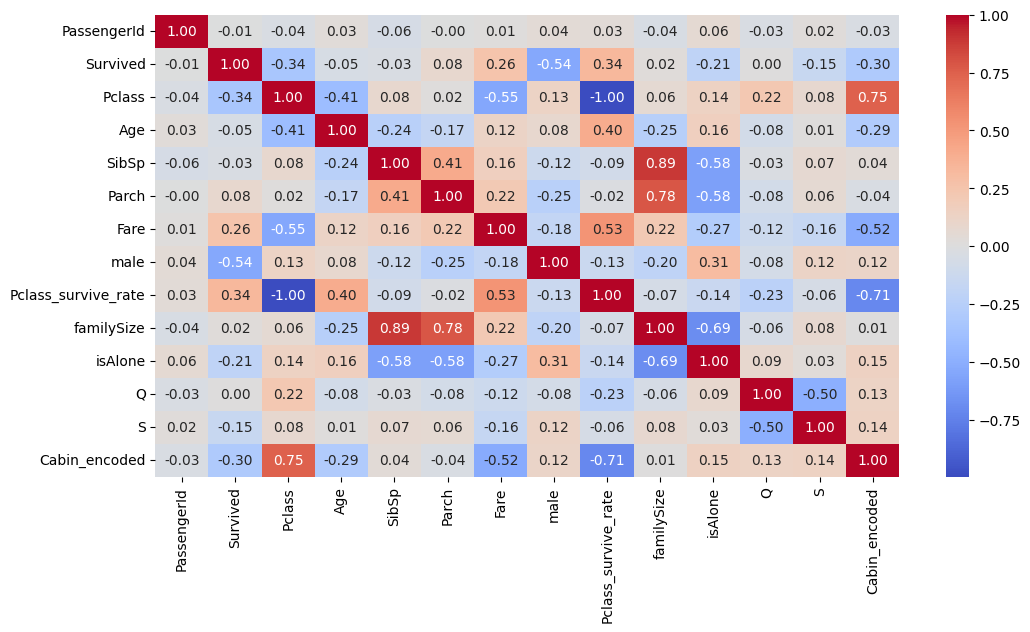

In [34]:
corr = df.select_dtypes(include=['number','float','boolean']).corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

Separando características dos rótulos.

In [35]:
X = df[['Age', 'male', 'Pclass', 'Fare', 'Cabin_encoded']]
y = df['Survived']

In [36]:
SEED = 85

### Rebalanceamento das classes com RandomUnderSampler

Redução do número de instâncias da classe majoritária para equilibrar as classes.

In [37]:
#y.value_counts()

In [38]:
# value_to_remove = int(y.value_counts()[0] * 0.75) # Adquirindo 75% do total de amostras de "não sobreviveu"
# rus = RandomUnderSampler(sampling_strategy={0:value_to_remove}, random_state=SEED)

In [39]:
# X_resampled, y_resampled = rus.fit_resample(X, y)

# df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
# sns.countplot(x='Survived', data=df_resampled)

In [40]:
# X = df_resampled.drop('Survived', axis=1)
# y = df_resampled['Survived']

# y.value_counts()

Separação em treino e teste (método HoldOut).

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=SEED)

print('Sobreviventes treino:', y_train.sum(), 'total:', len(y_train))
print('Sobreviventes teste:', y_test.sum(), 'total:', len(y_test))

Sobreviventes treino: 255 total: 666
Sobreviventes teste: 85 total: 223


### Treinamento e teste

In [42]:
def view_predict_scores(predicts, y_true):
    accuracy = accuracy_score(y_true, predicts)
    print(f'Acurácia: {accuracy*100:.2f}%')

    recall = recall_score(y_true, predicts, average='binary')
    print(f'Recall: {recall*100:.2f}%')

    precision = precision_score(y_true, predicts, average='binary')
    print(f'Precisão: {precision*100:.2f}%')

    f1_score_ = f1_score(y_true, predicts, average='binary')
    print(f'F1 Score: {f1_score_*100:.2f}%')

In [43]:
model_rt_h = RandomForestClassifier(max_depth=6, random_state=SEED)

model_rt_h.fit(X_train, y_train)

predicts_rt = model_rt_h.predict(X_test)

view_predict_scores(predicts_rt, y_test)

Acurácia: 81.17%
Recall: 64.71%
Precisão: 82.09%
F1 Score: 72.37%


In [44]:
pipeline_svc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', SVC())
])

pipeline_svc.fit(X_train, y_train)

predicts_svc = pipeline_svc.predict(X_test)

view_predict_scores(predicts_svc, y_test)

Acurácia: 75.78%
Recall: 60.00%
Precisão: 71.83%
F1 Score: 65.38%


In [45]:
pipeline_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)

predicts_knn = pipeline_knn.predict(X_test)

view_predict_scores(predicts_knn, y_test)

Acurácia: 81.17%
Recall: 67.06%
Precisão: 80.28%
F1 Score: 73.08%


In [46]:
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', XGBClassifier())
])

pipeline_xgb.fit(X_train, y_train)

predicts_xgb = pipeline_xgb.predict(X_test)

view_predict_scores(predicts_xgb, y_test)

Acurácia: 82.96%
Recall: 72.94%
Precisão: 80.52%
F1 Score: 76.54%


### Validação cruzada

In [47]:
def view_scores(results):
    test_mean = results['test_score'].mean()
    train_mean = results['train_score'].mean()

    print(f'Acurácia média treino: {train_mean*100:.2f}%')
    print(f'Acurácia média teste: {test_mean*100:.2f}%')
    print(f'Acurácia de teste entre {results["test_score"].min()*100:.2f}% e {results["test_score"].max()*100:.2f}%')

In [48]:
model_rt = RandomForestClassifier(max_depth=10, random_state=SEED)

rt_results = cross_validate(model_rt, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=True), return_train_score=True)
view_scores(rt_results)

Acurácia média treino: 94.46%
Acurácia média teste: 84.03%
Acurácia de teste entre 78.65% e 89.89%


Necessário criar uma pipeline para o SVC pois necessita que a cada iteração da validação cruzada seja realizado uma nova padronização dos dados.

In [49]:
pipeline_svc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', SVC())
])

svc_results = cross_validate(pipeline_svc, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=True), return_train_score=True)
view_scores(svc_results)

Acurácia média treino: 79.42%
Acurácia média teste: 76.72%
Acurácia de teste entre 70.79% e 82.02%


In [50]:
pipeline_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier())
])

svc_results = cross_validate(pipeline_knn, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=True), return_train_score=True)
view_scores(svc_results)

Acurácia média treino: 86.20%
Acurácia média teste: 82.34%
Acurácia de teste entre 76.40% e 87.64%


In [51]:
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', XGBClassifier())
])

svc_results = cross_validate(pipeline_xgb, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=True), return_train_score=True)
view_scores(svc_results)

Acurácia média treino: 96.40%
Acurácia média teste: 82.45%
Acurácia de teste entre 77.53% e 87.64%


### Busca de hiperparâmetros do melhor modelo baseado na validação cruzada

In [52]:
params = {
    'n_estimators': np.arange(100, 200, 10), # Quantidade de árvores que serão criadas na floresta aleatória
    'max_depth': np.arange(2,20,2), # Profundidade das árvores (complexidade)
    'criterion': ['gini', 'entropy', 'log_loss']
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=True)

randomizedSearch = RandomizedSearchCV(RandomForestClassifier(random_state=SEED),
                          params,
                          n_iter=20,
                          scoring='accuracy',
                          cv=kfold,
                          verbose=2,
                          n_jobs=-1,
                          random_state=SEED)

randomizedSearch.fit(X, y)
print(f'Melhor Score: {randomizedSearch.best_score_*100:.2f}%')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Melhor Score: 84.14%


In [53]:
# Validação Cruzada Aninhada
scores_randomizedSearch = cross_val_score(randomizedSearch, X, y, cv=kfold, n_jobs=-1)

scores_randomizedSearch.mean()

np.float64(0.8436287027579162)

### Testando um modelo de redes neurais

Normalização dos dados.

Nota: Foi testado também a padronização com StandardScaler, porém, o modelo teve um resultado ligeiramente menor em relação à normalização.

In [54]:
sc = MinMaxScaler()

# Houve uma melhor performance ao utilizar os dados escalados
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [55]:
model_keras = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)), # Camada oculta com 16 neurônios, função de ativação relu e define a dimensão de entrada como um vetor unidimensional com 7 colunas
    keras.layers.Dense(8, activation='relu'), # Camada oculta com 8 neurônios
    keras.layers.Dense(1, activation='sigmoid') # Camada de saída (probabilidade de sobrevivência)
])

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model_keras.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])

Criação de callbacks para parar o treinamento caso o desempenho não aumente (EarlyStopping) e salvar o melhor modelo baseado no valor de perda dos dados de validação (ModelCheckpoint).

In [57]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='checkpoint_best_model.keras', save_best_only=True)]

In [58]:
history = model_keras.fit(X_train_scaled, y_train,
                          epochs=100,
                          validation_data=(X_test_scaled, y_test),
                          callbacks=callbacks)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4222 - loss: 0.7165 - val_accuracy: 0.6861 - val_loss: 0.6704
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6938 - loss: 0.6576 - val_accuracy: 0.6592 - val_loss: 0.6421
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6619 - loss: 0.6356 - val_accuracy: 0.6906 - val_loss: 0.6254
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7023 - loss: 0.6141 - val_accuracy: 0.6996 - val_loss: 0.6110
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7161 - loss: 0.5908 - val_accuracy: 0.7040 - val_loss: 0.5975
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7419 - loss: 0.5743 - val_accuracy: 0.7309 - val_loss: 0.5837
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7506 - loss: 0.5727 - val_accuracy: 0.7220 - val_loss: 0.5705
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7679 - loss: 0.5469 - val_accuracy: 0.7354 - 

**Visualizando as métricas de acurácia no treino e teste**

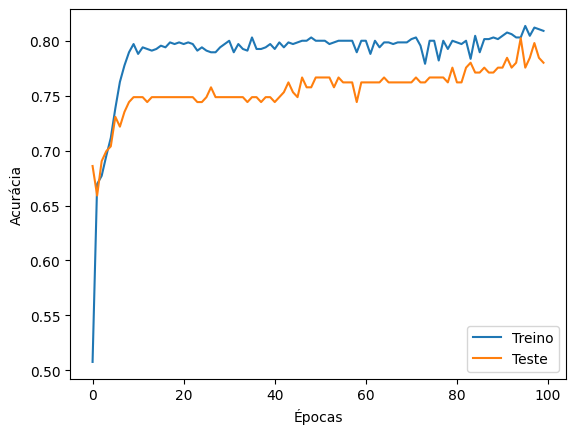

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend(['Treino', 'Teste'])

**Visualizando as métricas de perda no treino e teste**

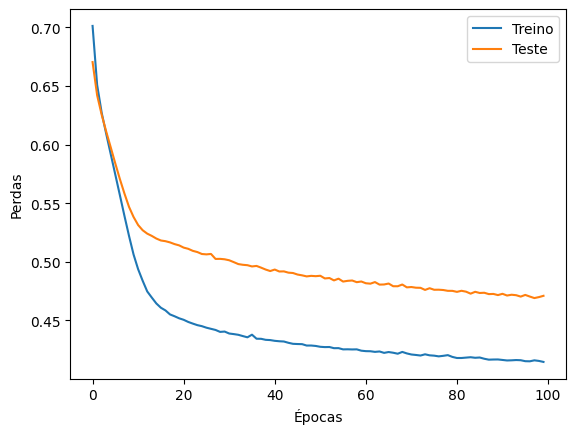

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Épocas")
plt.ylabel("Perdas")
plt.legend(['Treino', 'Teste'])

### Salvando o melhor modelo

In [61]:
joblib.dump(randomizedSearch.best_estimator_, 'random_forest_model.joblib')

['random_forest_model.joblib']